In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (에러 시 생략 가능)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import joblib

# ✅ 모델 번들 로드 함수
def load_model_with_assets(path='../Modeling/xgb_telco_bundle.pkl'):
    return joblib.load(path)

# ✅ 사용 예시
bundle = load_model_with_assets()

# 구성 요소 추출
model = bundle['model']
features = bundle['features']
threshold = bundle['threshold']
scaler = bundle['scaler']
label_encoder = bundle['label_encoder']  # 사용하지 않았다면 None일 수 있음

# 확인용 출력
print("📦 모델 구성 로드 완료")
print("✔️ 사용 피처 수:", len(features))
print("✔️ Threshold:", round(threshold, 4))


📦 모델 구성 로드 완료
✔️ 사용 피처 수: 56
✔️ Threshold: 0.4405



SHAP Summary Plot (bar)


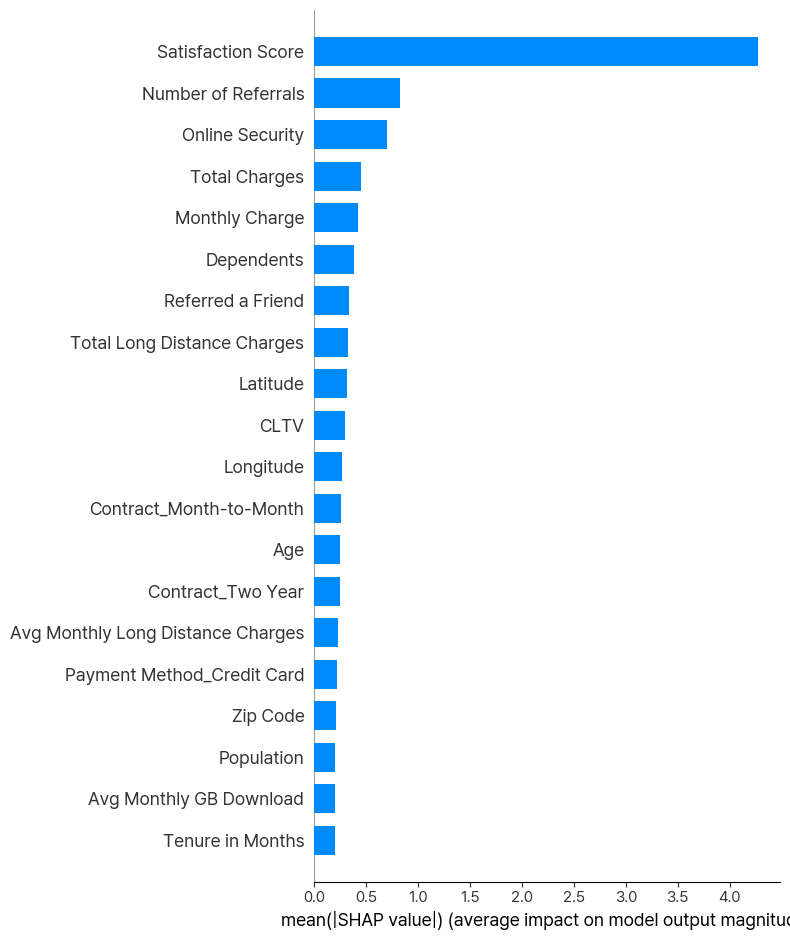


SHAP Summary Plot (dot)


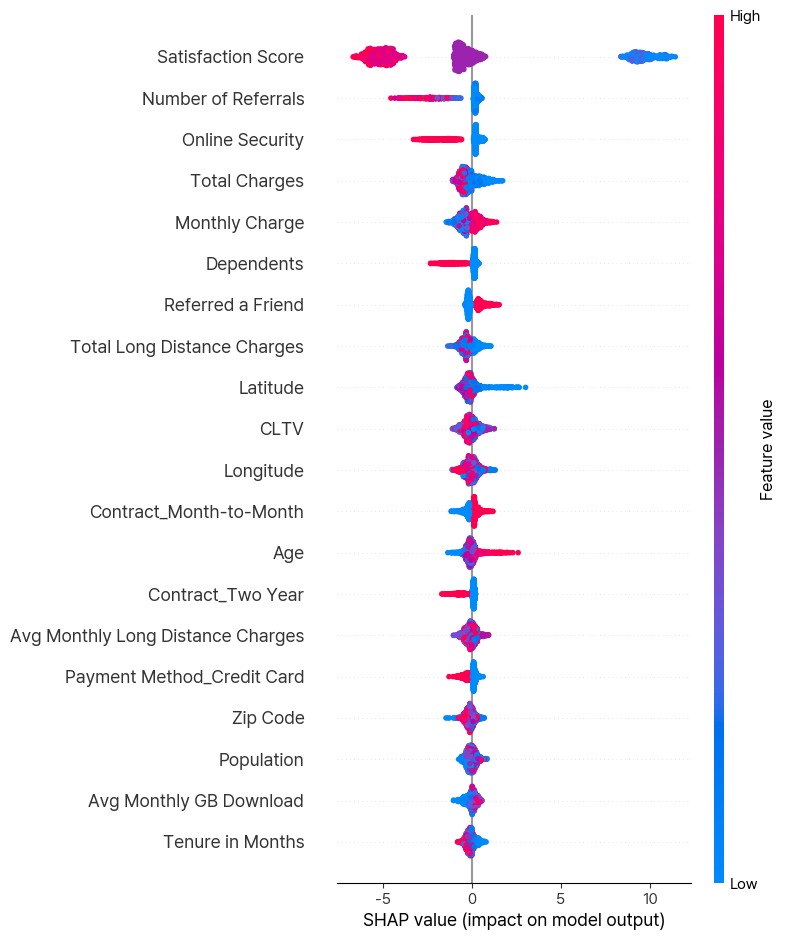


XGBoost Gain 기반 Feature Importance


<Figure size 640x480 with 0 Axes>

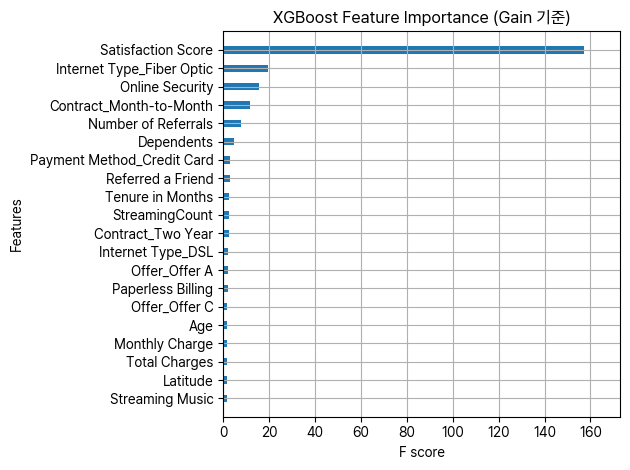

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from modules.preprocess_cols import (
    preprocess_telco_columns, add_derived_features,
    scale_numeric_features, load_model_with_assets
)
from modules.shap_analysis import run_shap_analysis

# 1. 원본 데이터 로딩
df_raw = pd.read_csv('../data/telco.csv')

# 2. 전처리
df_proc, _ = preprocess_telco_columns(df_raw)
df_proc = add_derived_features(df_proc)

# 3. 모델 번들 로드
bundle = load_model_with_assets()
model = bundle['model']
features = bundle['features']
scaler = bundle['scaler']

# 4. 스케일링
numeric_cols = df_proc.select_dtypes(include=['float64', 'int64']).columns.difference(['Churn']).tolist()
df_proc, _ = scale_numeric_features(df_proc, numeric_cols, scaler=scaler)

# 5. train/test split
X = df_proc[features]
y = df_proc['Churn']
_, X_test, _, _ = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. SHAP 분석
importance_df = run_shap_analysis(model=model, X_test=X_test, top_n=20, show_plot=True)


In [6]:
import shap

# SHAP explainer 생성
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [7]:
import numpy as np

# SHAP 값 평균 기준 상위 10개 변수만 추출
shap_importance = np.abs(shap_values).mean(axis=0)
shap_summary = pd.Series(shap_importance, index=X_test.columns)
shap_top10 = shap_summary.sort_values(ascending=False).head(10)

print("📌 SHAP Top 10 중요 변수")
display(shap_top10)

📌 SHAP Top 10 중요 변수


Satisfaction Score             4.272049
Number of Referrals            0.828413
Online Security                0.705425
Total Charges                  0.450649
Monthly Charge                 0.421407
Dependents                     0.382621
Referred a Friend              0.336749
Total Long Distance Charges    0.325931
Latitude                       0.313369
CLTV                           0.296954
dtype: float32

| 순위 | 변수명                           | SHAP 평균값 | 상대 영향력 (%) | 정량 해석                                                          |
| -- | ----------------------------- | -------- | ---------- | -------------------------------------------------------------- |
| 1  | `Satisfaction Score`          | **4.27** | **55.7%**  | 전체 모델 예측에서 절반 이상의 영향력을 갖는 **가장 핵심 변수**. 이 변수 하나로 이탈 확률이 크게 좌우됨 |
| 2  | `Number of Referrals`         | 0.83     | 10.8%      | 추천 횟수가 많을수록 이탈 위험이 낮아지는 경향. 영향력은 만족도 대비 약 1/5                  |
| 3  | `Online Security`             | 0.71     | 9.2%       | 보안 서비스 가입 여부가 이탈에 유의미한 기여. 비가입자에서 이탈 가능성 ↑                     |
| 4  | `Total Charges`               | 0.45     | 5.8%       | 누적 청구금이 낮은 고객은 신규 또는 미이용 → 이탈 가능성 ↑                            |
| 5  | `Monthly Charge`              | 0.42     | 5.5%       | 월 청구금액이 높을수록 이탈 위험 증가. 고요금군은 민감도 ↑                             |
| 6  | `Dependents`                  | 0.38     | 5.0%       | 가족 유무가 행동 패턴에 영향. 1인 가구의 이탈률이 높을 가능성                           |
| 7  | `Referred a Friend`           | 0.34     | 4.4%       | 친구 추천 경험 있는 고객은 이탈 위험 ↓. 브랜드 몰입도 요소로 작용                        |
| 8  | `Total Long Distance Charges` | 0.33     | 4.3%       | 장거리 통화 사용자는 이탈율 낮음. 전통 서비스 사용 선호 그룹일 수 있음                      |
| 9  | `Latitude`                    | 0.31     | 4.1%       | 위도(거주지)에 따라 이탈 패턴 차이 존재                                        |

| 구분            | 해석 요약                                                         |
| ------------- | ------------------------------------------------------------- |
| **1강 변수**     | `Satisfaction Score`: 모델 예측에 절대적 영향 (단독 4.27 / 총합 7.67)       |
| **2차 영향군**    | `Referrals`, `Online Security`: 각 10% 전후 영향. 서비스/행동 기반 전략 필요  |
| **3차 영향군**    | `Total Charges`, `Monthly Charge`, `Dependents` 등: 요금 + 고객 속성 |
| **지역·가치군 변수** | `Latitude`, `CLTV`: 세그먼트/군집 전략 연계 가능                          |

✅ 전략 연결
- Satisfaction Score가 3 이하인 고객은 이탈 위험 2배 이상 ↑
→ 만족도 기반 리텐션 전략: 즉시 설문 팝업 + 개선 대응 프로세스

- Monthly Charge 상위 20%는 SHAP 기준 영향력 > 0.4
→ 고요금 사용자에게는 혜택 재설계 또는 개인 맞춤형 요금제 안내 필요

- Online Security 미이용자군: 평균 0.7 이상 SHAP 기여
→ 보안 기능 무료 체험 알림 or 체험 쿠폰 제공